<a href="https://colab.research.google.com/github/avkornaev/Cells_counter/blob/main/01CC_Normalization_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary.

The cells counter very first step is calculation of the normalization parameters.

#**Install libraries**.



In [63]:
!pip install -Uqq fastbook
!pip install czifile
!pip install tifffile
!pip install imagecodecs

#**Connect to Google disk.**

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import libraries.**

In [65]:
import fastbook
from fastbook import *
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border, join_segmentations
import pandas as pd
import czifile
import imagecodecs
#import tifffile

#**Check the settings.**

In [66]:
print(os.getcwd()) # current directory

/content


In [67]:
#Image under study
path = Path('/content/drive/MyDrive/Cells_counter/Segmentation_Train_and_Validation_dataset/Images')

#Visualisation
img_size = [] # empty [] or rectangle coordinates, e.g. [0,0,1024,1024]
fig_size = (30,30) # figures size
img_map  = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_map1 = 'jet'

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255,255,255)
lineType  = 2

#Filtering
kernel = np.ones((5,5),np.uint8)
kernel4filt = 5
ps = 5 # patch_size
patchDist = 3 # patch_distance
hc = 115 # coefficient

numberOfIter = 2 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
dist_transf_param = 5
markers_bias = 100


#**Download "czi" images and create slices. Then calculate mean and standard deviation values.**

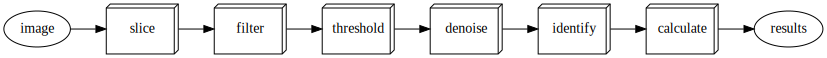

In [68]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

Path content.

In [69]:
path_list = path.ls()

Read an example of an image in the dataset.

In [70]:
img = czifile.imread(path_list[1])
img.shape

(1, 1, 1, 2, 1, 3277, 3277, 1)

In [71]:
img = czifile.imread(path_list[1])
img_size = [0,0,img.shape[5],img.shape[6]] # full size
img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix

img0 = img_slice[0,:,:] # 0 channel which is fluo4-T1 (highlights the apoptosed cells)
img1 = img_slice[1,:,:] # 1 channel which is H3342-T2 (highlights all the cells)
img2 = np.uint16(np.zeros(img0.shape))# 2 empty channel
channels = [img0,img1,img2] # channels of the image

nc = len(channels)
n = [i for i in range(nc)] # auxiliary variable

print('channel shape: ',channels[2].shape, channels[2].dtype, type(channels[2]))

channel shape:  (3277, 3277) uint16 <class 'numpy.ndarray'>


In [73]:
np.reshape(img0,(1,-1))

array([[0, 0, 0, ..., 1, 1, 2]], dtype=uint16)

In [84]:
np.concatenate([np.reshape(img0,(1,-1)),np.reshape(img0,(1,-1))], axis = 0)
# channels.append(channels)
# channels[2].shape

array([[0, 0, 0, ..., 1, 1, 2],
       [0, 0, 0, ..., 1, 1, 2]], dtype=uint16)

Read all images in the path and calculate mean and std values.

In [ ]:
#img_tensors = [tensor(czifile.imread(path_list[o])) for o in path_list]

In [ ]:
mean_values = [0]*nc
std_values = [0]*nc
imgf = [0]*nc

for i in range(len(path.ls())):
  img = czifile.imread(path_list[i]) # read czi image file
  img_size = [0,0,img.shape[5],img.shape[6]] # full size
  img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix
  imgf[0] = img_slice[0,:,:] # 0 channel which is fluo4-T1 (highlights the apoptosed cells)
  imgf[1] = img_slice[1,:,:] # 1 channel which is H3342-T2 (highlights all the cells)
  imgf[2] = np.uint16(np.zeros(imgf[0].shape))# 2 empty channel
  
  for j in n:
    if i < 1:
      channels[j] = imgf[j] # channels of the image
    else:
      print(channels[j].shape, imgf[j].shape)
      channels[j] = np.concatenate(channels[j],imgf[j])

#    mean_values[j] += np.mean(channels[j])/np #mean value
#    std_values[j] += np.std(channels[j])/np #standard deviation


    

In [ ]:
tensor(img0)

In [ ]:
print('CZI image shape: ',img.shape)# ?, ?, ?,number of chanels,x size,y size, ?
for i in n:
  print(i,'channel shape: ',channels[i].shape, channels[i].dtype, type(channels[i]))
  print(np.amax(channels[i]))
print('0 channel shape: ',img0.shape,img0.dtype,type(img0))
print(np.amax(img0))
print('1 channel shape: ',img1.shape,img1.dtype,type(img1))
print(np.amax(img1))

In [ ]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0)
dls.valid_ds.items[:3]

In [ ]:
img = czifile.imread(img_path + img_title)

if img_size == []:
  img_size = [0,0,img.shape[5],img.shape[6]] # full size

img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix
img0 = img_slice[0,:,:] # 0 channel which is fluo4-T1 (highlights the apoptosed cells)
img1 = img_slice[1,:,:] # 1 channel which is H3342-T2 (highlights all the cells)
channels = [img0,img1] # channels of the image

nc = len(channels)
n = [i for i in range(nc)] # auxiliary variable 

print('CZI image shape: ',img.shape)# ?, ?, ?,number of chanels,x size,y size, ?
for i in n:
  print(i,'channel shape: ',channels[i].shape, channels[i].dtype, type(channels[i]))
  print(np.amax(channels[i]))
print('0 channel shape: ',img0.shape,img0.dtype,type(img0))
print(np.amax(img0))
print('1 channel shape: ',img1.shape,img1.dtype,type(img1))
print(np.amax(img1))

**Create templates (empty lists).**

In [ ]:
channelsF = [0]*nc # filtered channels template
img_path_temp = [0]*nc # another one template
channelsFGray = [0]*nc # and another one
ret = [0]*nc # one more template
thresh = [0]*nc # one more template
opening = [0]*nc # one more template
sure_bg = [0]*nc # one more template
sure_fg = [0]*nc # one more template
ret1 = [0]*nc # one more template
dist_transform = [0]*nc # one more template
unknown = [0]*nc # one more template
ret2 = [0]*nc # one more template
markers = [0]*nc # one more template
markersi= [0]*nc # one more template
channelsFB = [0]*nc # one more template
channelsFW = [0]*nc # one more template
channelsFWi= [0]*nc # one more template
regions = [0]*nc
numberOfCells = [0]*nc

#**Filter channel images.**

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=1] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')
# https://laptrinhx.com/five-lessons-from-my-data-science-internship-at-hara-1112784335/

The non-local means denoising and the median filter are performed. 

In [ ]:
for i in n:
  # "denoise_nl_means" performs non-local means denoising
  sigma_est = np.mean(estimate_sigma(channels[i], multichannel=False))
  patch_kw = dict(patch_size=ps, patch_distance=patchDist, multichannel=False)
  channelsF[i] = denoise_nl_means(channels[i], h=hc*sigma_est, fast_mode=False, **patch_kw)
  
  channelsF[i] = np.uint16(channelsF[i])

  # Apply a multidimensional median filter
  channelsF[i] = ndimage.median_filter(channelsF[i], size=kernel4filt)

  print(i,'channel sigma estimation = ',sigma_est)
  print(i,'channel shape: ',channelsF[i].shape, channelsF[i].dtype, type(channelsF[i]))
  print(np.amax(channelsF[i]))
   

**Visualize channels before and after filtering.**

In [ ]:
titles = ['"fluo4-T1" channel highlights the apoptosed cells',
          '"H3342-T2" channel highlights all the cells']
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channels[i],cmap=img_map)
  plt.title(titles[i])
  plt.subplot(2,2,i+3)
  plt.imshow(channelsF[i],cmap=img_map)
  plt.title(titles[i]+'(filtered)')  

In [ ]:
#plt.figure(figsize=fig_size)
#plt.imshow(channelsF[1],cmap = img_map)

**Create tepmorary 'tiff' files.**

In [ ]:
for i in n:
  img_path_temp[i] = img_path + img_title[0:-4] + '_ch' + str(i) + '.tiff' # path 0
  cv2.imwrite(img_path_temp[i], channelsF[i]) # save channels in a temporary tiff file
print(img_path_temp)

**Read images using OpenCV.**

In [ ]:
for i in n:
  channelsFGray[i] = cv2.imread(img_path_temp[i],cv2.IMREAD_GRAYSCALE)
  print(type(channelsFGray[i]),channelsFGray[i].shape,channelsFGray[i].dtype)

#**Threshold and delete noise.**

Threshold image to binary using 'OTSU'. All the thresholded pixels are set to 255. Then remove noise using 'opening' and remove edge touching with 'clear_border' function (optional).

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=1] denoise[shape=box3d width=1 height=1] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [ ]:
for i in n:
  ret[i], thresh[i] = cv2.threshold(channelsFGray[i], 0, 255, 
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  opening[i] = cv2.morphologyEx(thresh[i],cv2.MORPH_OPEN,kernel,
                                iterations = numberOfIter)
  if clearBorder == 'on':
    opening[i] = clear_border(opening[i])

**Identify background and foreground area using OpenCV distance transformation. Apply watershed.**

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=1] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

Find sure background and sure foreground regions.

In [ ]:
for i in n:
  sure_bg[i] = cv2.dilate(opening[i],
                          kernel,iterations=numberOfIter) # sure background
  dist_transform[i] = cv2.distanceTransform(opening[i],cv2.DIST_L2,
                                            dist_transf_param)
  
  ret1[i], sure_fg[i] = cv2.threshold(dist_transform[i],
                                      dist_transf_ratio*dist_transform[i].max(),
                                      255,0)
  sure_fg[i] = np.uint8(sure_fg[i]) # sure foreground

To find the apoptosed cells the channels intersection condition should be met. The intersectioin is represented by 'and' logical operation.

In [ ]:
sure_fg[0] = cv2.bitwise_and(sure_fg[0], sure_fg[1])

Add markers and apply watershed.

In [ ]:
for i in n:
  unknown[i] = cv2.subtract(sure_bg[i], sure_fg[i])
  ret2[i], markers[i] = cv2.connectedComponents(sure_fg[i])
  markers[i] = markers[i] + markers_bias
  markers[i][unknown[i]==255] = 0

  markers[i] = cv2.watershed(cv2.imread(img_path_temp[i]),markers[i]) #The boundary regions will be marked as -1
  channelsFB[i] = cv2.imread(img_path_temp[i])
  channelsFB[i][markers[i] == -1] = [255,0,0] # highlight borders with red 
  channelsFW[i] = color.label2rgb(markers[i], bg_label = 0)

Visualize.

In [ ]:
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(sure_fg[i],cmap='binary_r')
  plt.title(titles[i]+'. Sure foreground.')
  plt.subplot(2,2,i+3)
  plt.imshow(markers[i],cmap=img_map1)
  plt.title(titles[i]+ '. Markers.')

Compare channels intersections to find the apoptosed cells.

In [ ]:
#channelsFWIntersection = cv2.bitwise_and(sure_fg[0], sure_fg[1])
#channelsFWIntersection = join_segmentations(sure_fg[0], sure_fg[1]) # intersection
#channelsFWIGray = cv2.cvtColor(channelsFWIntersection, cv2.COLOR_BGR2GRAY) # convert to gray image

In [ ]:
#retI,threshI = cv2.threshold(channelsFWIntersection, 0, 255, 
#                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#**Calculate metrics.**

https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=1]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [ ]:
# Calculate metrics for channels
for i in n:
  regions[i] = measure.regionprops(markers[i], intensity_image=channels[i])
  numberOfCells[i] = len(regions[i])-1
  #print(regions[i])
print('Numbers of cells in channel images are equal to',numberOfCells)
print('Note: the number of cells in channel 0 was calculated according to the intersecting condition.')

# # Calculate metrics for intersection
# regionsI = measure.regionprops(channelsFWIntersection, intensity_image=channels[0])
# numberOfApoptosedCells = len(regionsI)-1
# print('Numbers of appoptosed cells is equal to',numberOfApoptosedCells)


In [ ]:
#Append intersection
#regions.append(regionsI)

**Visualise and save metrics data.**

In [ ]:
d = [0]*(nc)
df_temp = [0]*(nc)

for i in [i for i in range(nc)]:
  nr = [i for i in range(len(regions[i]))]
  d[i] = pd.DataFrame()
  for j in nr:
    df_temp[i] = pd.DataFrame({'No':j, 
                          'Area (mum^2)':int(regions[i][j].area*(pixels2microns**2)),
                          'Equiv.diam. (mum)': regions[i][j].equivalent_diameter*pixels2microns,
                          'Major axis length (mum)':regions[i][j].major_axis_length*pixels2microns,
                          'Minor axis length (mum)':regions[i][j].minor_axis_length*pixels2microns,
                          'Mean intensity':regions[i][j].mean_intensity,
                          'Euler number': regions[i][j].euler_number,
                          'Centroid':[regions[i][j].centroid],
                          'Bounding box':[regions[i][j].bbox]})
    d[i] = pd.concat([d[i],df_temp[i]])
    d[i].to_csv(img_path + img_title[0:-4] +'_channel_'+str(i) + '.csv')  

In [ ]:
# Channel 0 ("fluo4-T1") intersected with Channel 1.
d[0]

In [ ]:
# Channel 1 ("H3342-T2").
d[1]

In [ ]:
# Channels intersection, that is a data frame of appoptosed cells
#d[2]

**Visualize boundaries and cells.**

In [ ]:
# Enumerate apoptosed cells on image
for j in [i for i in range(len(regions[0]))]:
  cellPosition = (regions[0][j].bbox[1],regions[0][j].bbox[0])
  cv2.putText(channelsFW[0],str(j),
              cellPosition,font,fontScale,fontColor,lineType)
# Visualize
fig, ax = plt.subplots(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channelsFB[i],cmap=img_map)
  plt.title(titles[i]+'. Detected boundaries.')
  plt.subplot(2,2,i+3)
  plt.imshow(channelsFW[i],cmap=img_map1)
  plt.title(titles[i]+ '. ' + str(numberOfCells[i]) + ' cell(s) were detected')

#**Compare the resulsts.**

Read csv file (if any) with data obtained from labeling on Apeer platform https://www.apeer.com/.

In [ ]:
if os.path.exists(img_path + img_title + '_annotation.csv') == True:
  dl = pd.read_csv(img_path + img_title + '_annotation.csv')
  print('The total number of cells is: ', len(dl), '(data from apeer.com)', numberOfCells[1],'(result of the current program);')
  print('The number of apoptosed cells is: ', len(dl[(dl.Class=='apoptosed')]), '(data from apeer.com)', numberOfCells[0],'(result of the current program).')
else:
    print('Labeling info obtained from apeer.com in a form of annotation file is absent.')

In [ ]:
#dl[(dl.Class=='alive')].head()

In [ ]:
#dl[(dl.Class=='apoptosed')].head()

#**Series results.**

Statistic data presented by 2 experts and 2 algorithm is used. The expert names are hidden. The algorihtm_1 is watershed (current programm), the algorithm_2 is semantic segmentation.  

In [ ]:
#sr = pd.read_excel(img_path + 'Comparison.xlsx', index_col=None, na_values=["NA"])

In [ ]:
#sr.head()

In [ ]:
#sr[sr['Set']=='2021-02-16']

#**Some links.**

Image Filtering https://cs.nyu.edu/~fergus/teaching/vision/3_filtering.pdf

Cells count https://www.biorxiv.org/content/10.1101/181495v2.full